<a href="https://colab.research.google.com/github/ReemAlsharabi/KAUST-Academy/blob/main/Adv%20/Day1/MNIST_PyTorch_CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we will implement a Convoulutional Neural Network (CNN) using pytorch for MNIST Classification.

Expectations: Please provide solutions to the questions in the cells at the end of the notebook.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models,transforms
from torchvision.utils import make_grid
from torchvision.datasets import MNIST
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader

We will be using MNIST Disgits datasets. The MNIST Digits dataset consists of 70000 28x28 grayscale images of digits from 0 to 9, with 6000 images per class. There are 60000 training images and 10000 test images. <br>

Following are the some random samples from the dataset.

![MNIST Samples](https://www.yunzhew.com/project/mnist-digit-net/featured_hudee2c27f78ea2485e0d3aa44abbfc53c_218555_720x2500_fit_q75_h2_lanczos_3.webp)

We will use pytorch datasets to fetch the MNIST Digits dataset as it provides a handy way to get and use the dataset. More information about pytorch datasets [here](https://pytorch.org/vision/stable/datasets.html).

In [2]:
batch_sz=64 # this is batch size i.e. the number of rows in a batch of data

train_dataset = MNIST(root='./datasets', train=True, download=True, transform = transforms.ToTensor())
test_dataset = MNIST(root='./datasets', train=False, download=True, transform = transforms.ToTensor())

train_loader = DataLoader(train_dataset, batch_size = batch_sz)
test_loader = DataLoader(test_dataset, batch_size = batch_sz)

100%|██████████| 9912422/9912422 [00:00<00:00, 97109108.93it/s]


Extracting ./datasets/MNIST/raw/train-images-idx3-ubyte.gz to ./datasets/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 115587494.11it/s]


Extracting ./datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25376903.56it/s]


Extracting ./datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ./datasets/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 13350055.20it/s]


Extracting ./datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



In [3]:
len(train_loader)

938

In [50]:
batch  = next(iter(train_loader))
batch[0].shape

torch.Size([64, 1, 28, 28])

## Convolutional Neural Networks

Now, we will construct a Convolutional Neural Network. Convolutional neural networks are a type of neural networks which are typically applied to image data. They work by convolving a filter on an image. Filters act as weights of CNN and we learn these filters to extract useful information from an image. Filters are also sometimes called kernels.
<br>

We element-wise muliply a filter with a patch of input data and then sum the result.<br>
$$z_{ij} = W \star x_{ij} = \sum^{m-1}_{a=0}\sum^{m-1}_{b=0} W_{ab} \: x_{(i+a)(j+b)}$$
![convolution](https://upload.wikimedia.org/wikipedia/commons/1/19/2D_Convolution_Animation.gif) [source](https://commons.wikimedia.org/wiki/File:2D_Convolution_Animation.gif)

<br>

A convolutional layer in a CNN consists of a number applying a number of such filters to the input. The output of each of these filters is stacked in the form of multiple channels (just like we have 3 channesl in an RGB image). The filters then also become 3-dimensional.

![2d conv](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*oFVlkvZp848nh-QoD3pREw.png) [source](https://towardsdatascience.com/a-comprehensive-introduction-to-different-types-of-convolutions-in-deep-learning-669281e58215)

### Stride

When we are dealing with convolution on images of very large size, its not always required to convolve over each and every pixel of an image. So we can set the subsequent convolutions to be shifted by more than one pixel in either the vertical or horizontal axis. This shift in subsequent convolutions is called the stride.

![stride](https://miro.medium.com/v2/resize:fit:1400/1*BNLPHcNxLCgtwlJHnSs9oA.gif) [source](https://medium.com/swlh/convolutional-neural-networks-part-2-padding-and-strided-convolutions-c63c25026eaa)

### Pooling

The pooling operation involves sliding a two-dimensional filter over each channel of feature map and summarising the features lying within the region covered by the filter. 

Pooling layers are used to reduce the dimensions of the feature maps and summarising the featre maps.

Types of Pooling Layers:
1.   Max Pooling: <br>
Max pooling is a pooling operation that selects the maximum element from the region of the feature map covered by the filter. This is the most commonly used pooling layer.
![Max Pooling](https://media.geeksforgeeks.org/wp-content/uploads/20190721025744/Screenshot-2019-07-21-at-2.57.13-AM.png) [source](https://www.geeksforgeeks.org/cnn-introduction-to-pooling-layer/)


2.   Average Pooling: <br>
Average pooling computes the average of the elements present in the region of feature map covered by the filter.
![Avg Pooling](https://media.geeksforgeeks.org/wp-content/uploads/20190721030705/Screenshot-2019-07-21-at-3.05.56-AM.png) [source](https://www.geeksforgeeks.org/cnn-introduction-to-pooling-layer/)



### Convolutional Neural Network
A common CNN model architecture is to have a number of convolution and pooling layers stacked one after the other.
![cnn](https://indiantechwarrior.com/wp-content/uploads/2021/04/LeNet-1024x393.png) [source](https://indiantechwarrior.com/convolutional-neural-network-architecture/)



We will use the categorical crossentropy loss here which is traditionally used for classification.

$$\mathcal{L} = \frac{1}{N} \sum^{N}_{i=1} \left ( \sum^{C}_{j=1} -y_{i,j}\: log(\hat{y}_{i,j}) \right )$$

where $y_i,j$ is the groundtruth, $\hat{y}_{i,j}$ is the prediction, $C$ is the number classes and $N$ is the number of data samples.

In [4]:
#Q1: define a 2 layer simple NN for mnist digit classificaiton

In [51]:
#Q2: Define a CNN with 2 conv layer and 2 linear layers for mnist digit classification

class CNNs(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1,8, 3, 1) #a single channel representing the intensity values,8 filters (output channels), a kernel size of 3x3, and a stride of 1.
    self.conv2 = nn.Conv2d(8, 16, 3, 1)

    self.linear1 = nn.Linear(16*5*5, 100) # the first linear layer linear1. It takes the flattened output from the previous convolutional layer (conv2) with a shape of 16x5x5 (16 channels, each with a spatial size of 5x5) and produces an output of size 100
    self.linear2 = nn.Linear(100, 10)


  def forward(self, x):
    # x-->(bs, 1, 28, 28)
    x = self.conv1(x)
    x = torch.relu(x)
    # x -->(bs,8, 26, 26)
    # output_size = [(input_size - kernel_size + 2 * padding) / stride] + 1
    x = F.max_pool2d(x, (2,2)) #after applying the first convolutional layer (conv1) and the subsequent max pooling operation, the spatial dimensions of the tensor are halved. 
    # x -->(bs,8, 13, 13)
    x = self.conv2(x)
    x = torch.relu(x)
    # x -->(bs,16, 11, 11)
    x = F.max_pool2d(x, (2,2))
    # x -->(bs,16, 5, 5)
    x = x.view(-1, 16*5*5)
    x = self.linear1(x)
    x = torch.relu(x)
    x = self.linear2(x)
    return x

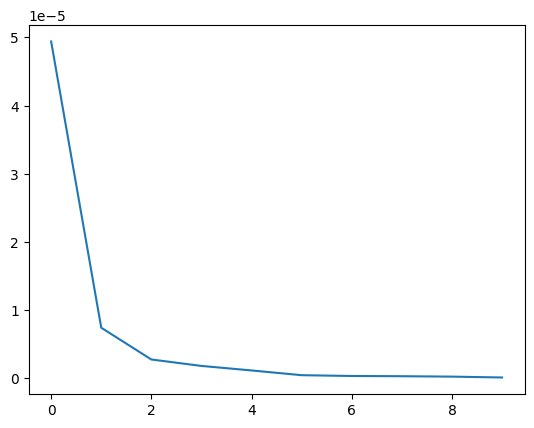

In [61]:
#Q3: Train both networks for 10 epochs and compare their performance 
from numpy.lib.twodim_base import tri
device = torch.device("cuda:0")
net = CNNs().to(device)
num_epochs=10
lr=0.1
momentum=0.5
ls=[]

opt=optim.SGD(net.parameters(),lr=lr,momentum=momentum)

for i in range(num_epochs):
  for batch in train_loader:
    x,y=batch[0].to(device),batch[1].to(device)
    yhat=net(x)
    loss=F.cross_entropy(yhat,y)
    opt.zero_grad()
    loss.backward()
    opt.step()
    total_loss=+loss.item()
  ls.append(total_loss/len(train_loader))

plt.plot(ls)

In [62]:
#Q4: Compare the accuarcay of both networks on the test set

incorrect_samples = []

for i in range(num_epochs):
    for batch in test_loader:
        x, y = batch[0].to(device), batch[1].to(device)
        outputs = net(x)
        _, predicted = torch.max(outputs.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()

        incorrect_indices = (predicted != y).nonzero()[:, 0]
        incorrect_samples.extend(x[incorrect_indices])

accuracy = 100 * correct / total
print(f"Accuracy: {accuracy}%")

Accuracy: 97.36021931287524%


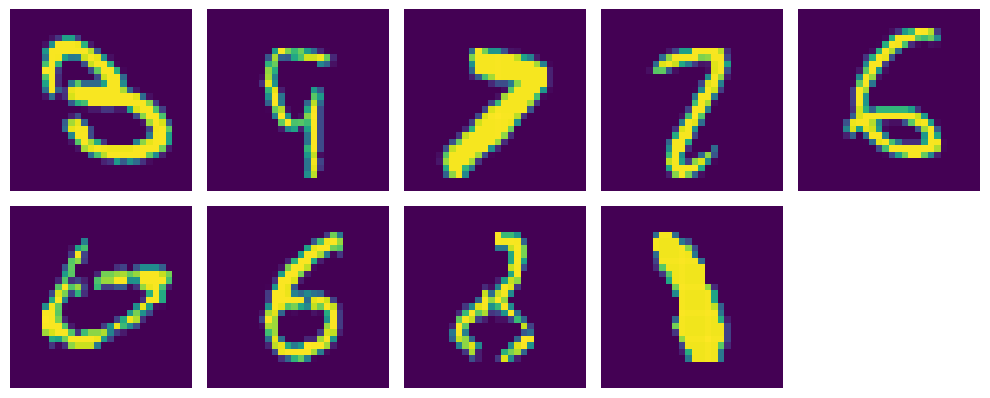

In [65]:
#Q5: go through the testset and plot some samples of incorrect results
plt.figure(figsize=(10, 10))
for i in range(min(9, len(incorrect_samples))):
    plt.subplot(5, 5, i + 1)
    plt.imshow(incorrect_samples[i].cpu().numpy().transpose(1, 2, 0))
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
#Q6: show the output of the intermediate layers

In [ ]:
#Q7: Compare the time of training on CPU and GPU